In [ ]:
!pip install einops
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 343.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange
from functools import partial
from math import sqrt
from functools import partial
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

# helpers

def exists(val):
    return val is not None

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

# classes

class DsConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride=1, bias=True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size=kernel_size, padding=padding, groups=dim_in, stride=stride, bias=bias),
            nn.Conv2d(dim_in, dim_out, kernel_size=1, bias=bias)
        )
    def forward(self, x):
        return self.net(x)

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

class EfficientSelfAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        heads,
        reduction_ratio
    ):
        super().__init__()
        self.scale = (dim // heads) ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(dim, dim, 1, bias=False)
        self.to_kv = nn.Conv2d(dim, dim * 2, reduction_ratio, stride=reduction_ratio, bias=False)
        self.to_out = nn.Conv2d(dim, dim, 1, bias=False)

    def forward(self, x):
        h, w = x.shape[-2:]
        heads = self.heads

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim=1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h=heads), (q, k, v))

        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = F.softmax(sim, dim=-1)

        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) c -> b (h c) x y', h=heads, x=h, y=w)
        return self.to_out(out)

class MixFeedForward(nn.Module):
    def __init__(
        self,
        *,
        dim,
        expansion_factor
    ):
        super().__init__()
        hidden_dim = dim * expansion_factor
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            DsConv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1)
        )

    def forward(self, x):
        return self.net(x)

class MiT(nn.Module):
    def __init__(
        self,
        *,
        channels,
        dims,
        heads,
        ff_expansion,
        reduction_ratio,
        num_layers
    ):
        super().__init__()
        stage_kernel_stride_pad = ((7, 4, 3), (3, 2, 1), (3, 2, 1), (3, 2, 1))

        dims = (channels, *dims)
        dim_pairs = list(zip(dims[:-1], dims[1:]))

        self.stages = nn.ModuleList([])

        for (dim_in, dim_out), (kernel, stride, padding), num_layers, ff_expansion, heads, reduction_ratio in zip(dim_pairs, stage_kernel_stride_pad, num_layers, ff_expansion, heads, reduction_ratio):
            get_overlap_patches = nn.Unfold(kernel, stride=stride, padding=padding)
            overlap_patch_embed = nn.Conv2d(dim_in * kernel ** 2, dim_out, 1)

            layers = nn.ModuleList([])

            for _ in range(num_layers):
                layers.append(nn.ModuleList([
                    PreNorm(dim_out, EfficientSelfAttention(dim=dim_out, heads=heads, reduction_ratio=reduction_ratio)),
                    PreNorm(dim_out, MixFeedForward(dim=dim_out, expansion_factor=ff_expansion)),
                ]))

            self.stages.append(nn.ModuleList([
                get_overlap_patches,
                overlap_patch_embed,
                layers
            ]))

    def forward(
        self,
        x,
        return_layer_outputs=False
    ):
        h, w = x.shape[-2:]

        layer_outputs = []
        for (get_overlap_patches, overlap_embed, layers) in self.stages:
            x = get_overlap_patches(x)

            num_patches = x.shape[-1]
            ratio = int(sqrt((h * w) / num_patches))
            x = rearrange(x, 'b c (h w) -> b c h w', h=h // ratio)

            x = overlap_embed(x)
            for (attn, ff) in layers:
                x = attn(x) + x
                x = ff(x) + x

            layer_outputs.append(x)

        ret = x if not return_layer_outputs else layer_outputs
        return ret

class Segformer(nn.Module):
    def __init__(
        self,
        *,
        dims=(32, 64, 160, 256),
        heads=(1, 2, 5, 8),
        ff_expansion=(8, 8, 4, 4),
        reduction_ratio=(8, 4, 2, 1),
        num_layers=2,
        channels=3,
        decoder_dim=256,
        num_classes=4
    ):
        super().__init__()
        dims, heads, ff_expansion, reduction_ratio, num_layers = map(partial(cast_tuple, depth=4), (dims, heads, ff_expansion, reduction_ratio, num_layers))
        assert all([*map(lambda t: len(t) == 4, (dims, heads, ff_expansion, reduction_ratio, num_layers))]), 'only four stages are allowed, all keyword arguments must be either a single value or a tuple of 4 values'

        self.mit = MiT(
            channels=channels,
            dims=dims,
            heads=heads,
            ff_expansion=ff_expansion,
            reduction_ratio=reduction_ratio,
            num_layers=num_layers
        )

        self.to_fused = nn.ModuleList([nn.Sequential(
            nn.Conv2d(dim, decoder_dim, 1),
            nn.Upsample(size=(512, 1024), mode='bilinear', align_corners=False)  # Ensure output size matches target mask size
        ) for i, dim in enumerate(dims)])

        self.to_segmentation = nn.Sequential(
            nn.Conv2d(4 * decoder_dim, num_classes, 1),
        )

    def forward(self, x):
        layer_outputs = self.mit(x, return_layer_outputs=True)

        fused = [to_fused(output) for output, to_fused in zip(layer_outputs, self.to_fused)]
        fused = torch.cat(fused, dim=1)
        return self.to_segmentation(fused)


In [ ]:
# prompt: mount the drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import os

# Define a custom dataset class
class PalmLeafDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

        self.image_filenames = sorted(os.listdir(image_folder))
        self.mask_filenames = sorted(os.listdir(mask_folder))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        mask_filename = self.mask_filenames[idx]

        image_path = os.path.join(self.image_folder, image_filename)
        mask_path = os.path.join(self.mask_folder, mask_filename)

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
])

# Define paths to the dataset folders
image_folder = '/content/drive/My Drive/Project/Data_Chunks_2/Original'
mask_folder = '/content/drive/My Drive/Project/Data_Chunks_2/Masked'

# Create dataset instance
dataset = PalmLeafDataset(image_folder, mask_folder, transform=transform)

# Create data loader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define binary cross-entropy loss
criterion = nn.BCEWithLogitsLoss()

# Define the modified SegformerBinary model
class SegformerBinary(Segformer):
    def __init__(self, **kwargs):
        super(SegformerBinary, self).__init__(**kwargs)
        self.to_segmentation = nn.Sequential(
            nn.Conv2d(4 * kwargs['decoder_dim'], 1, 1),  # Output a single channel for binary segmentation
        )

# Instantiate the modified SegformerBinary model
model = SegformerBinary(
    dims=(32, 64, 160, 256),
    heads=(1, 2, 5, 8),
    ff_expansion=(8, 8, 4, 4),
    reduction_ratio=(8, 4, 2, 1),
    num_layers=2,
    channels=3,
    decoder_dim=256,
)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in data_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(data_loader)}')

print('Training finished.')


Epoch [1/2], Loss: 0.6542774438858032
Epoch [2/2], Loss: 0.494684100151062
Training finished.


In [ ]:
# Define the path to save the model
model_path = '/content/drive/My Drive/Project/segformer_model.pth'

# Save the model state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


NameError: name 'model' is not defined

In [ ]:
!pip install h5py


In [ ]:
import h5py

# Define the path to save the model
model_path_h5 = '/content/drive/My Drive/Project/segformer_model.h5'

# Save the model
with h5py.File(model_path_h5, 'w') as f:
    # Create a group to store model weights
    model_weights_group = f.create_group('model_weights')

    # Save the state dictionary of the model
    for name, param in model.state_dict().items():
        model_weights_group.create_dataset(name, data=param.cpu().numpy())

print(f"Model saved to {model_path_h5}")


Model saved to /content/drive/My Drive/Project/segformer_model.h5


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Define a function to load and preprocess an image
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((512, 1024)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Define the paths to the saved model and the image you want to test
model_path = '/content/drive/My Drive/Project/Model/segformer_model.pth'
image_path = '/content/drive/My Drive/Project/Data_Chunks_2/Original/MaI286_025.jpg_slice1.png'  # Replace 'path_to_your_image.jpg' with the actual path to your image


class SegformerBinary(Segformer):
    def __init__(self, **kwargs):
        super(SegformerBinary, self).__init__(**kwargs)
        self.to_segmentation = nn.Sequential(
            nn.Conv2d(4 * kwargs['decoder_dim'], 1, 1),  # Output a single channel for binary segmentation
        )

# Load the model
model = SegformerBinary(
    dims=(32, 64, 160, 256),
    heads=(1, 2, 5, 8),
    ff_expansion=(8, 8, 4, 4),
    reduction_ratio=(8, 4, 2, 1),
    num_layers=2,
    channels=3,
    decoder_dim=256,
)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Load and preprocess the image
image = load_image(image_path)

# Perform inference
with torch.no_grad():
    output = model(image)

# Convert the output to binary mask (0s and 1s)
binary_mask = torch.sigmoid(output).cpu().numpy()
binary_mask = np.where(binary_mask > 0.5, 1, 0)  # Thresholding at 0.5

# Now you can use the binary mask for further processing or visualization


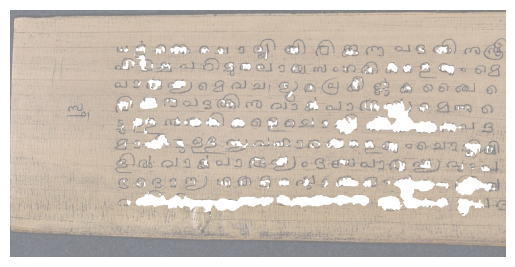

In [ ]:
import matplotlib.pyplot as plt

# Load the original image
original_image = Image.open(image_path)

# Overlay the binary mask onto the original image
overlay = original_image.copy()
overlay.putalpha(128)  # Set transparency to 50%

# Convert the binary mask to a PIL Image
binary_mask_image = Image.fromarray((binary_mask.squeeze() * 255).astype(np.uint8))

# Resize the binary mask image to match the original image size
binary_mask_image = binary_mask_image.resize(original_image.size, Image.NEAREST)

# Composite the binary mask onto the overlay image
overlay.paste(binary_mask_image, (0, 0), binary_mask_image)

# Display the overlay image
plt.imshow(overlay)
plt.axis('off')
plt.show()


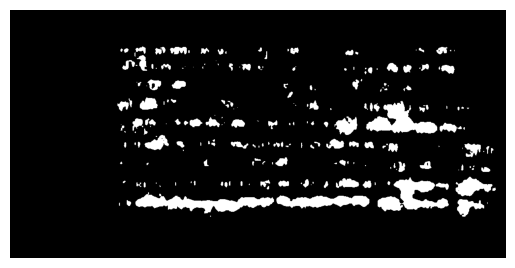

In [ ]:
import matplotlib.pyplot as plt

# Convert the binary mask to a PIL Image
binary_mask_image = Image.fromarray((binary_mask.squeeze() * 255).astype(np.uint8))

# Display the binary mask image
plt.imshow(binary_mask_image, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Define a function to load and preprocess an image
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((512, 1024)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Define the paths to the saved model and the image you want to test
model_path = '/content/drive/My Drive/Project/Model/segformer_model_200.pth'
image_path = '/content/drive/My Drive/Project/Data_Full_Image/Original/MaI14_003.jpg.png'  # Replace 'path_to_your_image.jpg' with the actual path to your image


class SegformerBinary(Segformer):
    def __init__(self, **kwargs):
        super(SegformerBinary, self).__init__(**kwargs)
        self.to_segmentation = nn.Sequential(
            nn.Conv2d(4 * kwargs['decoder_dim'], 1, 1),  # Output a single channel for binary segmentation
        )

# Load the model
model = SegformerBinary(
    dims=(32, 64, 160, 256),
    heads=(1, 2, 5, 8),
    ff_expansion=(8, 8, 4, 4),
    reduction_ratio=(8, 4, 2, 1),
    num_layers=2,
    channels=3,
    decoder_dim=256,
)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Load and preprocess the image
image = load_image(image_path)

# Perform inference
with torch.no_grad():
    output = model(image)

# Convert the output to binary mask (0s and 1s)
binary_mask = torch.sigmoid(output).cpu().numpy()
binary_mask = np.where(binary_mask > 0.5, 1, 0)  # Thresholding at 0.5

# Now you can use the binary mask for further processing or visualization


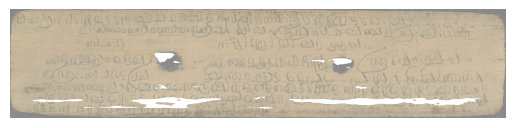

In [ ]:
import matplotlib.pyplot as plt

# Load the original image
original_image = Image.open(image_path)

# Overlay the binary mask onto the original image
overlay = original_image.copy()
overlay.putalpha(128)  # Set transparency to 50%

# Convert the binary mask to a PIL Image
binary_mask_image = Image.fromarray((binary_mask.squeeze() * 255).astype(np.uint8))

# Resize the binary mask image to match the original image size
binary_mask_image = binary_mask_image.resize(original_image.size, Image.NEAREST)

# Composite the binary mask onto the overlay image
overlay.paste(binary_mask_image, (0, 0), binary_mask_image)

# Display the overlay image
plt.imshow(overlay)
plt.axis('off')
plt.show()


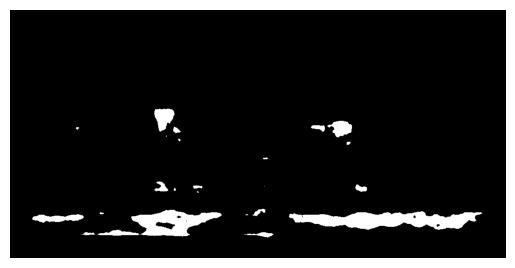

In [ ]:
import matplotlib.pyplot as plt

# Convert the binary mask to a PIL Image
binary_mask_image = Image.fromarray((binary_mask.squeeze() * 255).astype(np.uint8))

# Display the binary mask image
plt.imshow(binary_mask_image, cmap='gray')
plt.axis('off')
plt.show()
